<a href="https://colab.research.google.com/github/vduran18/Neural-Nets/blob/master/ValeriaDuran_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
#import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal, RandomUniform, TruncatedNormal
from tensorflow.keras import optimizers, losses
from tensorflow.keras import callbacks
from time import time
import seaborn as sns
from scipy.stats import norm
from pandas import DataFrame as df
from sklearn.metrics import plot_confusion_matrix
import itertools

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving housing.csv to housing.csv


In [ ]:
import io
dat = pd.read_csv(io.BytesIO(uploaded['housing.csv']))

**Describe your Data set and the associated classification task**

In [ ]:
#number of cases in dat before reduction
dat_cases = len(dat)
print(dat_cases, 'cases before reduction')

20640 cases before reduction


In [ ]:
dat['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The practical goal of the original classification task is to predict the proximity of future houses to the ocean given these attributes. <br>
The number of cases is 20640 cases. <br>
The number of features per case is 9 features. <br>
There are 5 original classes and their names are 'Near Bay', '<1H Ocean', 'Inland', 'Near Ocean', and 'Island'. <br>
The features names are 'Longitude', 'Latitude', 'Housing Median Age', 'Total Rooms', 'Total Bedrooms', 'Population', 'Households', 'Median Income', and 'Median House Value'. <br>
'Longitude' represents the measure of how far west a house is. The higher the value the further west it is. <br>
'Latitude' represents the measure of how far north a house is. The higher the value the further north it is. <br>
'Housing Median Age' represents the median age of a house within a block. A lower value means it is a newer building. <br>
'Total Rooms' represents the total number of rooms within a block. <br>
'Total Bedrooms' represents the total number of bedrooms within a block. <br>
'Population' represents the total number of people residing within a block. <br>
'Households' represents the total number of households, a group of people residing within a home unit, for a block. <br>
'Median Income' represents the median income for households within a block of houses (measured in tens of thousands of US Dollars). <br>
'Median House Value' represents the median house value for households within a block (measured in US Dollars). <br>
All the features are continuous. <br>
Since all of these features are not necessary for the task, we will reduce the dataset in order to ease the performance of our neural network.

In [ ]:
# Clean the DS

# Drop the 'Longitude' and 'Latitude' columns
dat_drop_cols = dat.drop(['longitude', 'latitude'], axis = 1)

# Drop the 'Island' and 'Near Bay' classes
dat_drop_island = dat_drop_cols.loc[dat_drop_cols['ocean_proximity'] != 'ISLAND', :]
dat_drop_nearbay = dat_drop_island.loc[dat_drop_island['ocean_proximity'] != 'NEAR BAY', :]

# Drop the rows with NA values
dat_drop_na = dat_drop_nearbay.dropna().reset_index(drop=True)

# Clone 'Near Ocean' Class
dat_nearocean = dat_drop_na.loc[dat_drop_na['ocean_proximity'] == 'NEAR OCEAN']
dat_clean = pd.concat([dat_drop_na, dat_nearocean]).reset_index(drop=True)

# Reduce each class in the dataset by a factor of 4 using random subsampling
dat_1hocean = dat_clean.loc[dat_clean['ocean_proximity'] == '<1H OCEAN', :]
dat_inland = dat_clean.loc[dat_clean['ocean_proximity'] == 'INLAND', :]
dat_nearocean = dat_clean.loc[dat_clean['ocean_proximity'] == 'NEAR OCEAN', :]

RDS_1hocean = dat_1hocean.sample(n = round((len(dat_1hocean))/4), random_state = 1)
RDS_inland = dat_inland.sample(n = round((len(dat_inland))/4), random_state = 1)
RDS_nearocean = dat_nearocean.sample(n = round((len(dat_nearocean))/4), random_state = 1)

RDS = pd.concat([RDS_1hocean, RDS_inland, RDS_nearocean]).reset_index(drop = True)
RDS.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,36.0,1084.0,202.0,920.0,199.0,3.7279,162200.0,<1H OCEAN
1,47.0,1648.0,346.0,1120.0,338.0,2.0042,114200.0,<1H OCEAN
2,8.0,1115.0,412.0,1472.0,396.0,3.1392,146200.0,<1H OCEAN
3,42.0,1558.0,322.0,884.0,334.0,2.2304,203800.0,<1H OCEAN
4,16.0,2918.0,444.0,1697.0,444.0,5.3062,195500.0,<1H OCEAN


In [ ]:
# Number of cases after reduction
RDS_cases = len(RDS)
print('RDS has', RDS_cases, 'cases')

RDS has 5196 cases


In [ ]:
# Compute the kept class sizes

RDS['ocean_proximity'].value_counts()

<1H OCEAN     2258
INLAND        1624
NEAR OCEAN    1314
Name: ocean_proximity, dtype: int64

The new number of cases is 5196 cases. <br>
The number of kept features per case is 7 features. <br>
There are 3 original classes kept and their names are '<1H Ocean', 'Inland', and 'Near Ocean'. <br>
The 'Near Ocean' class was cloned, so the class size doubled. <br>
All 3 classes were then reduced by a factor of 4 to run the algorithm in a timely manner. <br>
After removing the NA rows and the 'Island' and 'Near Bay' classes, the '<1H Ocean' class has 2258 cases, the 'Inland' class has 1624 cases, and the 'Near Ocean' class has 1314 cases. <br>
The kept features names are 'Housing Median Age', 'Total Rooms', 'Total Bedrooms', 'Population', 'Households', 'Median Income', and 'Median House Value'. <br>
**The following table describes the mean and standard deviation of each feature corresponding to each class:**

In [ ]:
RDS.groupby('ocean_proximity').describe().loc[:, (slice(None), ['mean', 'std'])].T

ocean_proximity              <1H OCEAN         INLAND     NEAR OCEAN
housing_median_age mean      29.243136      24.748768      29.605784
                   std       11.619151      12.001527      11.836787
total_rooms        mean    2668.558459    2714.030172    2544.273212
                   std     2229.057700    2380.657259    2048.345973
total_bedrooms     mean     548.250664     535.757389     530.828767
                   std      417.266048     453.553725     384.069295
population         mean    1545.134190    1406.044335    1341.917047
                   std     1227.679339    1195.588133    1087.959520
households         mean     520.635075     483.581281     496.506088
                   std      386.842264     402.870083     356.772847
median_income      mean       4.254645       3.182202       3.989324
                   std        1.977510       1.419449       1.952445
median_house_value mean  239877.292737  123250.434729  250772.974886
                   std   105376.213207   69236.124242  119920.212616

As we can see, median_house_value has a substantially greater standard deviation and mean due to the units, therefore standardizing the data will be required in order to accurately use the data.

In [ ]:
# Seperate the X and Y in RDS
RDS_X = RDS.drop('ocean_proximity', axis = 1)
RDS_Y = RDS['ocean_proximity']

# Center and Rescale RDS
# The standardized data set will have a global mean = 0 and global std = 1  

RDS_scaled = pd.DataFrame(data = preprocessing.scale(RDS_X), columns = RDS_X.columns)
print('Scaled Data Head:\n', RDS_scaled.head(), '\n')

RDS_scaled_xy = RDS_scaled.copy()
RDS_scaled_xy['ocean_proximity'] = RDS_Y

Scaled Data Head:
    housing_median_age  total_rooms  ...  median_income  median_house_value
0            0.673283    -0.701424  ...      -0.066462           -0.384259
1            1.591032    -0.449020  ...      -0.986938           -0.803630
2           -1.662807    -0.687551  ...      -0.380835           -0.524049
3            1.173873    -0.489297  ...      -0.866145           -0.020804
4           -0.995352     0.119337  ...       0.776368           -0.093320

[5 rows x 7 columns] 



In [ ]:
#CL1 = data_scaled[data_scaled['class']==1]
CL1 = RDS_scaled_xy[RDS_scaled_xy['ocean_proximity']=='<1H OCEAN']
CL2 = RDS_scaled_xy[RDS_scaled_xy['ocean_proximity']=='INLAND']
CL3 = RDS_scaled_xy[RDS_scaled_xy['ocean_proximity']=='NEAR OCEAN']

After scaling the data, we will split the data into a training set of 80% and a test set of 20%. 

In [ ]:
np.random.seed(2)
X_train1, X_test1, y_train1, y_test1 = train_test_split(CL1.iloc[:,:7], CL1.iloc[:,7], test_size = 0.2, random_state = 2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(CL2.iloc[:,:7], CL2.iloc[:,7], test_size = 0.2, random_state = 2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(CL3.iloc[:,:7], CL3.iloc[:,7], test_size = 0.2, random_state = 2)
X_train = pd.concat([X_train1,X_train2,X_train3]) 
X_test = pd.concat([X_test1, X_test2, X_test3]) 
y_train = pd.concat([y_train1,y_train2, y_train3]) 
y_test = pd.concat([y_test1,y_test2, y_test3])
print('TRAIN size =', len(X_train))
print('TEST size =', len(X_test))

TRAIN size = 4156
TEST size = 1040


In [ ]:
# Compute new sizes of the classes within TRAIN

TRAIN_xy = X_train.copy()
TRAIN_xy['ocean_proximity'] = y_train
print('Class Sizes in TRAIN:')
TRAIN_xy['ocean_proximity'].value_counts()

Class Sizes in TRAIN:


<1H OCEAN     1806
INLAND        1299
NEAR OCEAN    1051
Name: ocean_proximity, dtype: int64

In [ ]:
# Compute new sizes of the classes within TEST

TEST_xy = X_test.copy()
TEST_xy['ocean_proximity'] = y_test
print('Class Sizes in TEST:')
TEST_xy['ocean_proximity'].value_counts()

Class Sizes in TEST:


<1H OCEAN     452
INLAND        325
NEAR OCEAN    263
Name: ocean_proximity, dtype: int64

In [ ]:
# Proportions of cases in each class for the training set

TRAIN_xy['ocean_proximity'].value_counts()/len(X_train)

<1H OCEAN     0.434552
INLAND        0.312560
NEAR OCEAN    0.252887
Name: ocean_proximity, dtype: float64

In [ ]:
# Proportions of cases in each class for the test set

TEST_xy['ocean_proximity'].value_counts()/len(X_test)

<1H OCEAN     0.434615
INLAND        0.312500
NEAR OCEAN    0.252885
Name: ocean_proximity, dtype: float64

The proportions of cases in each class for the test set and for the training set are similar for each class.

In [ ]:
# Convert labels to one hot encodings
label_encoder = LabelEncoder()
YTRAIN = label_encoder.fit_transform(y_train)
YTEST = label_encoder.fit_transform(y_test)

In [ ]:
Y_train = to_categorical(YTRAIN)
Y_test = to_categorical(YTEST)

**Select 2 tentative sizes h for the hidden layer**


0.97
h95 = 4


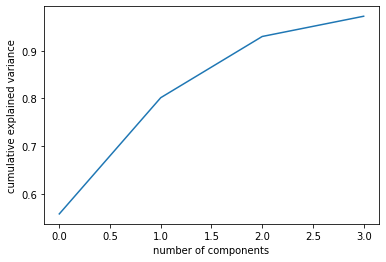

In [ ]:
pca = PCA(0.95) # apply pca for 95%
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print(np.around(sum(pca.explained_variance_ratio_),2))
h95=pca.n_components_
print('h95 =', h95)


PCA(0.95) signifies that the amount of variance that needs to be explained has to be greater than 95%. We computed the cumulative sum ratios against the number of eigenvalues that would give us a preservation of greater than 95% variance and concluded that the number of princicipal components was 4 since the highest variance explained by PCA is 97%. Therefore, h95 = 4.


In [ ]:
#HL = U1 + U2 + U3
HL=0
for i in range(3):
  pca_Mij=PCA(0.95)
  pca_Mij.fit(X_train.iloc[YTRAIN==i,:])
  HL+=pca_Mij.n_components_
  print(HL)
#HL = 12
print('\nHL =', HL)

4
8
12

HL = 12


U1 = 4 <br>
U2 = 8 <br>
U3 = 12

In [ ]:
hl = 12 + 8 + 4
print(hl)

24


We then performed PCA analysis again, but this time on the input vector corresponding to the classes [1,2,3]. We computed the smallest number U1, U2, and U3 that preserves more than 95% of the variation. We defined hl = U1 + U2 + U3 = 24.

 **Define the MLP architecture of an Automatic Classifier with r =3 classes**

For our first version of the MLP model, we equate our Layer 1 dimension to the amount of features in our training set [7 features], we equate our Hidden Layer to hl95 [4], and we equate our Layer 2 to the amount of classes we have [3 classes]. <br>
We chose "RandomNormal" for our kernel initializer and bias, as well as a categorical cross entropy loss function, a stochastic gradient descent optimizer, and accuracy for the metrics. <br>
We also began our MLP with a decay rate of 0.04, a batch size of 100, a learning rate of 0.1, and an epoch size of 100. We chose to stop our model if after 10 epochs the results did not improve. 

In [ ]:
h = 4 #start with hl95
Initializer = RandomNormal(mean=0.0, stddev=0.05, seed=1)
B = 100
decay_rate = 0.04

In [ ]:
### Use your own layer size and initializers. Refer to https://keras.io/initializers/. ####
#Create a model function to use on h95 and HL
def Best_Model(X_train, y_train, X_test, y_test, layerH_dim = h, Initializer = Initializer, B = B, decay_rate = decay_rate):
  
  #Build the Model for Keras
  layer1_dim=X_train.shape[1]
  layerH_dim=layerH_dim
  layer2_dim=3


  # Setup the layer
  model = Sequential()

  # From layer 1 to layer H, we use RELU
  # the initial Weights and Thresholds are kernel and bias
  # use random normal for a random normal distribution 
  model.add(Dense(layerH_dim, activation='relu', input_dim=layer1_dim, 
                kernel_initializer=Initializer,
                bias_initializer=Initializer))

  # From layer H to 2, then softmax
  model.add(Dense(layer2_dim, activation='softmax', 
                kernel_initializer=Initializer, 
                bias_initializer=Initializer))

  ###### Configure your own learning rate schedule and mini-batch size. #########

  # Choose batch size
  N=X_train.shape[0] # number of cases in train set
  # Our task is classification and we use cross entropy
  loss_fn = losses.CategoricalCrossentropy()

  # Define learning rate
  lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                    decay_steps=N/B, 
                                                    decay_rate=np.exp(-decay_rate), 
                                                    staircase=True)

  # Because of using batch, Stochastic Gradient Descent optimizer is a must
  model.compile(optimizer=optimizers.SGD(learning_rate=lr_schedule), 
              loss=loss_fn,
              metrics=['accuracy'])

  # For saving the best model during the whole training process.
  checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

  #### Interrupt training if `val_loss` stops improving for over 10 epochs #######
  stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
  # Save the weight at the end of each epoch
  #weight_record = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', 
                                    # save_weights_only=True)
  epoch=100

  # Fit the model
  Monitor = model.fit(X_train, y_train, 
                    epochs=epoch, 
                    batch_size=B, 
                    callbacks=[checkpointer,stop_learn],
                    validation_data=(X_test, y_test),
                    verbose = 0
                    )
  
  return Monitor.history['loss'], Monitor.history['val_loss'], Monitor.history['accuracy'], Monitor.history['val_accuracy']

***fix this***
The soft max function turns the output from the output layer into probabilities by taking the exponents of each output and then normalizing each value by the sum of those exponents; the entire output vector from the softmax function would add up to 1 and have a dimension of 3. For example, if the softmax function outputs a vector of probabilities [0.7,0.2,0.1] for case(n), where [x,y,z] are the probabilites for Class 1, Class 2, and Class 3, respectively, then it will assign case(n) as Class 1.

We decided to begin our process by first testing the MLP with our different parameters in order to find the best results. To begin, we started this process by first testing the MLP with hl95 and HL.  

In [ ]:
#create a function to plot the results
def plot(results):
  keys = results.keys()

  #Plot the plots
  count = 0
  max_acc = 0
  fig, ax = plt.subplots(2,1, figsize = (12,15))
  for i in keys:
    ax[0].plot(results[i]['loss'])
    ax[1].plot(results[i]['val_accuracy'])
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss (Average Cross Entropy)')
  ax[0].set_title('Loss per parameter')
  ax[0].legend(['{}'.format(i) for i in results.keys()])
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Validation Set Accuracy')
  ax[1].legend(['{}'.format(i) for i in results.keys()])

  for i in results.keys():
    #Get the best key (using the highest accuracy)
    key_max = max(results[i]['val_accuracy'])
    if key_max > max_acc:
      max_acc = key_max
      best_key = i

  #for i in keys:
    #print(min(results[i]['loss']), max(results[i]['val_accuracy']))
  
  plt.show()
  return best_key

In [ ]:
h = [4,24]
h_results = {}
delta_times = []
for i in h:
  a = time()
  loss, val_loss, accuracy, val_accuracy = Best_Model(X_train, Y_train, X_test, Y_test, layerH_dim= i)
  h_results[i] = {'loss' : loss,
                  'val_loss': val_loss,
                  'accuracy': accuracy,
                  'val_accuracy': val_accuracy}
  delta_times += [time()-a]

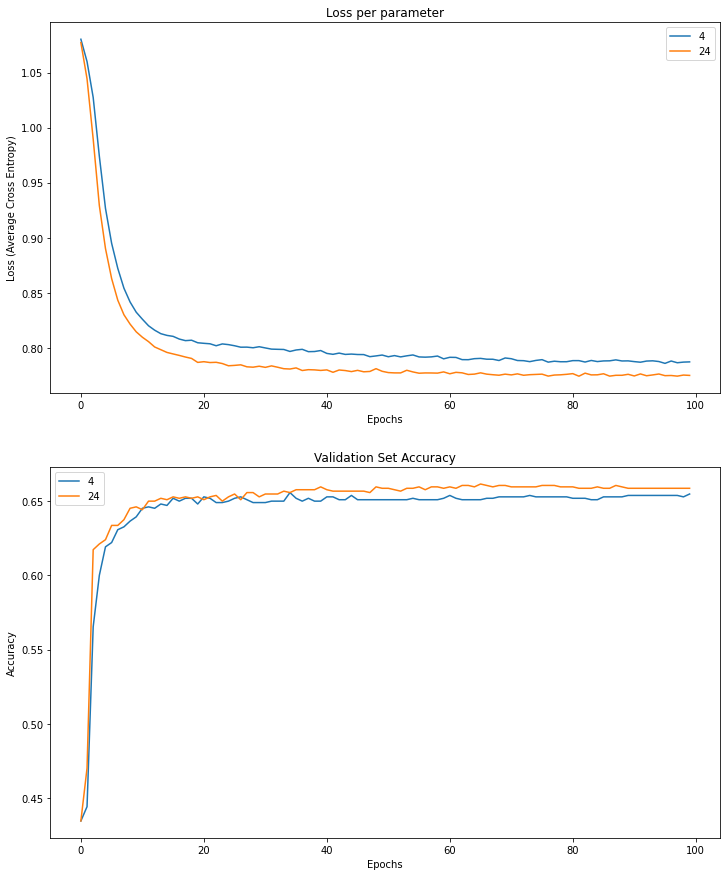

Number of Epochs: 100
Best Hidden Layer Dimension: 24
Time for each parameter:  [9.359  8.4796]


In [ ]:
best_h = plot(h_results)
print('Number of Epochs: {}\nBest Hidden Layer Dimension: {}'.format(len(h_results[i]['loss']), best_h))
print('Time for each parameter: ', np.around(delta_times,4))


In [ ]:
for i in list(h_results.keys()):
  print(i)
  print(np.around(min(h_results[i]['loss']),2), np.around(max(h_results[i]['val_accuracy']),4))

4
0.79 0.6558
24
0.77 0.6615


The top graph shows the average cross entropy loss over the size of epochs for the parameter, which in this specific case was the hidden layer dimension while the bottom graph shows the validation set accuracy for the parameter as well. The validation set used is just the x_test and y_test used when fitting the MLP model <br>
The function ran for the 100 epochs. <br>
Based on the top graph, we can see that hl = 24 has a lower average cross entropy error (77% compared to 79%) which is good since we want this error to be as small as possible. The validation accuracy is also higher (66% compared to 65%). Based off of the results, we decided that a hidden layer of dimension 24 is the best choice to move forward. 

**Impact of various learning options**

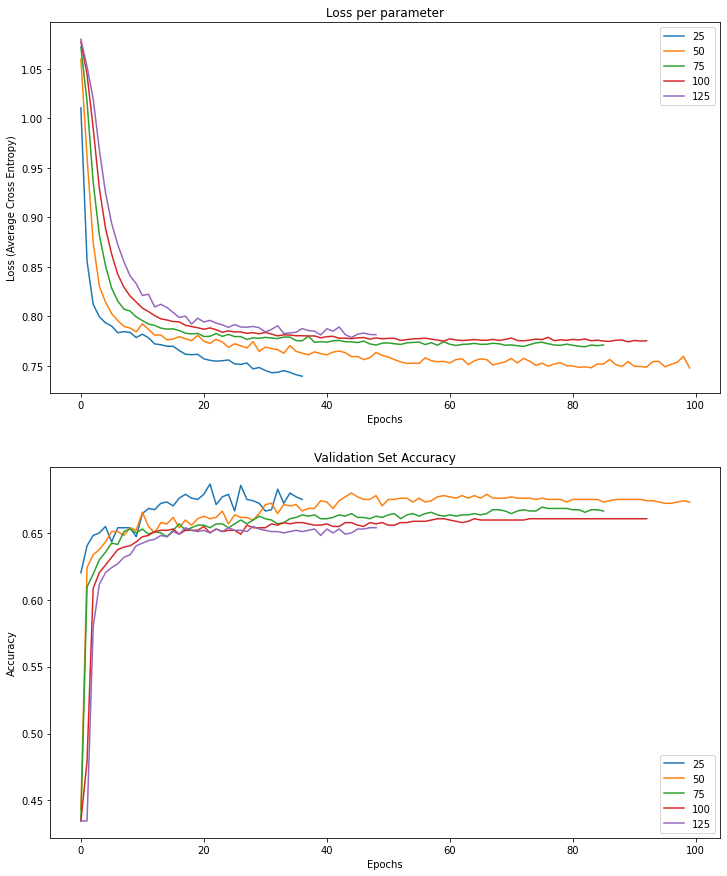

Number of Epochs: 49
Best Number of Batches Dimension: 25
Time for each parameter:  [ 6.7255 11.5582  8.4825  7.9507  4.0836]


In [ ]:
#Try different batch sizes
#So far number of epochs = 100 and best h is 24
B=[25, 50,75, 100, 125]

B_results = {}
delta_times = []
for i in B:
  a = time()
  loss, val_loss, accuracy, val_accuracy = Best_Model(X_train, Y_train, X_test, Y_test, layerH_dim=best_h, B = i)
  B_results[i] = {'loss' : loss,
                  'val_loss': val_loss,
                  'accuracy': accuracy,
                  'val_accuracy': val_accuracy}
  delta_times += [time()-a]

best_B = plot(B_results)
print('Number of Epochs: {}\nBest Number of Batches Dimension: {}'.format(len(B_results[i]['loss']), best_B))
print('Time for each parameter: ', np.around(delta_times,4))

In [ ]:
for i in list(B_results.keys()):
  print(i)
  print(np.around(min(B_results[i]['loss']),2), np.around(max(B_results[i]['val_accuracy']),2))
  #print(np.mean(B_results[i]['loss']), np.mean(B_results[i]['val_accuracy']))

25
0.74 0.69
50
0.75 0.68
75
0.77 0.67
100
0.77 0.66
125
0.78 0.65


49 epochs were used. <br>
The top plot shows that the larger the batch size, the higher the loss (Average Cross Entropy). <br> 
The bottom plot indicates that regardless of the batch size, the validation accuracy appears to be around the same range. <br>
Based on the best results, the batch size of 25 has the highest validation accuracy of 69% with a cross entropy loss of 74%. We hope that as we further progress, we can bring this cross entropy loss lower. 

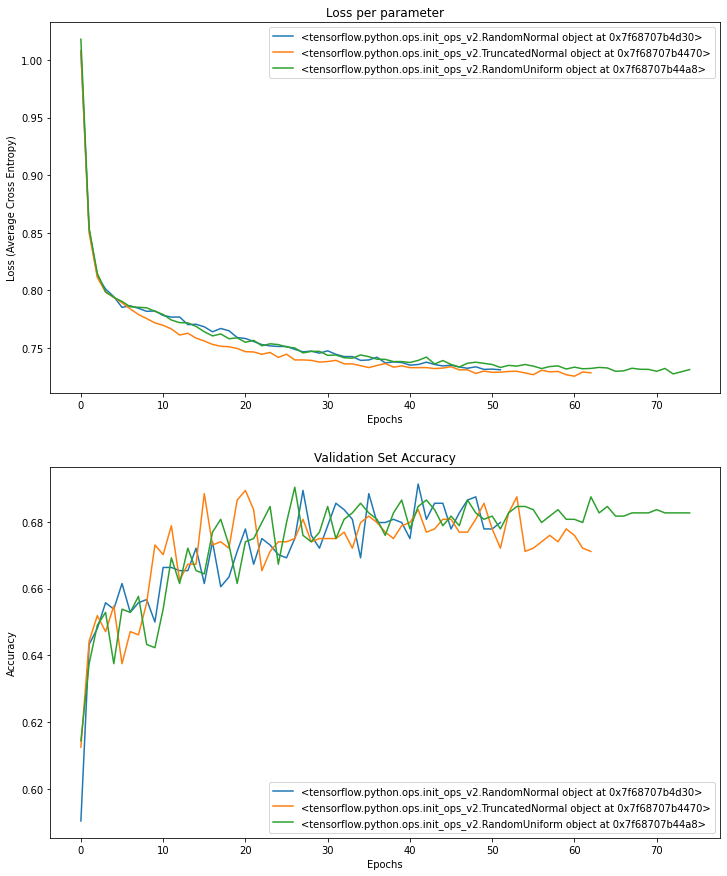

Number of Epochs: 75
Best Initialization Method Dimension: <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7f68707b4d30>
Time for each parameter:  [ 9.4277 11.135  13.413 ]


In [ ]:
#Try different Initialization Methods
#So far h = 24 (100 epochs before stopping)
# batch size = 25 (100 epochs before stopping)
Initializer = [RandomNormal(mean=0.0, stddev=0.05, seed=1),
               TruncatedNormal(mean=0.0, stddev=0.05, seed=1),
               RandomUniform(minval=-0.05, maxval=0.05, seed=1)]

Init_results = {}
delta_times = []
for i in Initializer:
  a = time()
  loss, val_loss, accuracy, val_accuracy = Best_Model(X_train, Y_train, X_test, Y_test, layerH_dim=best_h, B = best_B, Initializer=i)
  Init_results[i] = {'loss' : loss,
                  'val_loss': val_loss,
                  'accuracy': accuracy,
                  'val_accuracy': val_accuracy}
  delta_times += [time() - a]

best_Init = plot(Init_results)
print('Number of Epochs: {}\nBest Initialization Method Dimension: {}'.format(len(Init_results[i]['loss']), best_Init))
print('Time for each parameter: ', np.around(delta_times,4))

In [ ]:
for i in list(Init_results.keys()):
  print(i)
  print(np.around(min(Init_results[i]['loss']),2), np.around(max(Init_results[i]['val_accuracy']),2))

0.73 0.69
0.73 0.69
0.73 0.69


As we can see, the function stopped running after 75 epochs. The initialization method that gave us the best results was RandomNormal. This method gave us a cross entropy loss of 73% with a validation accuracy of 69%. However, as we can see from the results above, the inialization method seems to not have a large effect on the accuracy or cross entropy loss. 

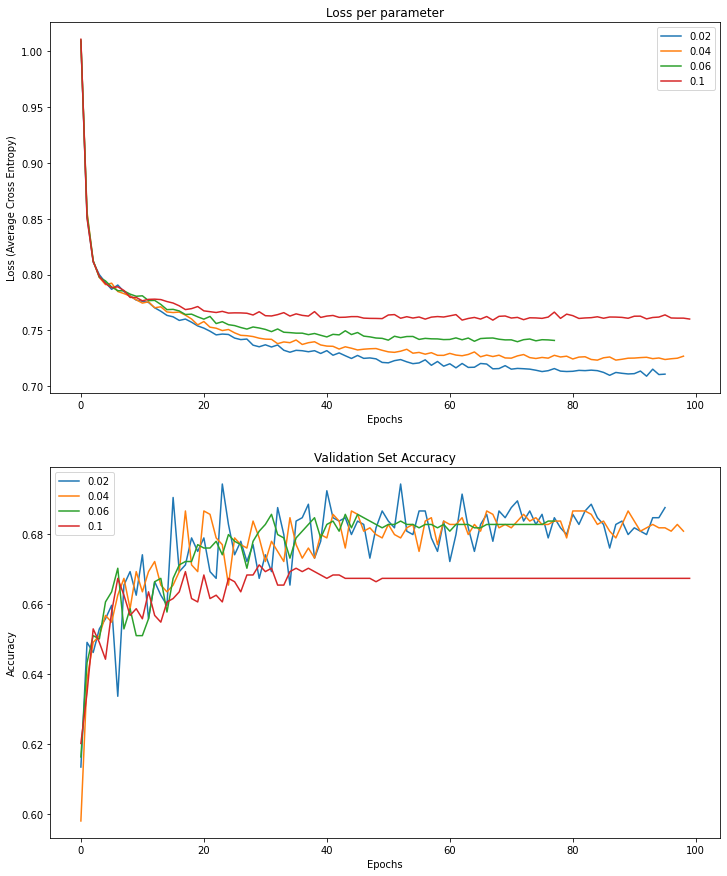

Number of Epochs: 100
Best Decay Rate Dimension: 0.02
[16.9833 17.5275 15.1438 17.9699]


In [ ]:
#Try different Decay Rates
#So far h = 24 (100 epochs before stopping)
# batch size = 25 (59 epochs before stopping)
# initializer = RandomNormal(mean=0.0, stddev=0.05, seed=1) (75 epochs before stopping)
decay_rate = [.02, .04, .06, .10]

decay_results = {}
delta_times = []
for i in decay_rate:
  a = time()
  loss, val_loss, accuracy, val_accuracy = Best_Model(X_train, Y_train, X_test, Y_test, layerH_dim=best_h, B = best_B, Initializer=best_Init, decay_rate = i)
  decay_results[i] = {'loss' : loss,
                  'val_loss': val_loss,
                  'accuracy': accuracy,
                  'val_accuracy': val_accuracy}
  delta_times += [time() - a]

best_decay = plot(decay_results)
print('Number of Epochs: {}\nBest Decay Rate Dimension: {}'.format(len(decay_results[i]['loss']), best_decay))
print(np.around(delta_times,4))

In [ ]:
for i in list(decay_results.keys()):
  print(i)
  print(np.around(min(decay_results[i]['loss']),2), np.around(max(decay_results[i]['val_accuracy']),2))

0.02
0.71 0.69
0.04
0.72 0.69
0.06
0.74 0.69
0.1
0.76 0.67


The function ran for 100 epochs. <br>
Each color represents a different decay rate. Based on the top plot, we can see that the rates have different average cross entropy losses. On the bottom plot, We can also see that the rates have a very similar validation accuracy. <br>
However, when comparing the minimum cross entropy loss and maximum validation accuracy for each decay rate, we can see that the function chooses a decay rate of 0.02 as the best rate, with a cross entropy loss of 71% and a validation accuracy of 69%.

The best parameters are: 
1. Best hidden layer : 24 (Uses all 100 epochs)
2. Best batch size : 25 (uses all 59 epochs)
3. Best initializer : RandomNormal (uses 75 epochs before stopping)
4. Best decay rate: 0.02 (uses 100 epochs)

In [ ]:
#Just for running the def Model_Search() since I set these values equal to values
best_h = 24
best_Init = RandomNormal(mean=0.0, stddev=0.05, seed=1)
best_B = 25
best_decay = 0.02

# Use your own layer size and initializers. Refer to https://keras.io/initializers/.
layer1_dim=X_train.shape[1]
layerH_dim=best_h
layer2_dim=3

D = layer1_dim*layerH_dim + layerH_dim + layerH_dim*layer2_dim + layer2_dim

# Setup the layer
model = Sequential()

#Edit the initializers
Initializer = best_Init

# From layer 1 to layer H, we use RELU
# the initial Weights and Thresholds are kernel and bias
# Random normal = random from normal distribution (mean=0.0, stddev=0.05, seed=None)
model.add(Dense(layerH_dim, activation='relu', input_dim=layer1_dim, 
                kernel_initializer=Initializer,
                bias_initializer=Initializer))

# From layer H to 2, then softmax
model.add(Dense(layer2_dim, activation='softmax', 
                kernel_initializer=Initializer, 
                bias_initializer=Initializer))

In [ ]:
# Configure your own learning rate schedule and mini-batch size.

# Choose batch size
B = best_B
N=X_train.shape[0] # number of cases in train set
# Set Decay Rate 
decay_rate = np.exp(-best_decay)
# Our task is classification and we use cross entropy so
loss_fn = losses.CategoricalCrossentropy()

# Define learning rate
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                    decay_steps=N/B, 
                                                    decay_rate=decay_rate, 
                                                    staircase=True)

# Because of using batch, Stochastic Gradient Descent optimizer is a must
model.compile(optimizer=optimizers.SGD(learning_rate=lr_schedule), 
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
class MyHistory(callbacks.Callback):
    # Set empty list for values we want to retrieve at the begining
    def on_train_begin(self, logs={}):
        self.grads = []
        self.gradsNorm = []
        self.train_loss = []
        self.test_loss = []
        self.weight=[]
        self.WC = []
        #Track some of the batch values
        self.bW = []
        self.b_WC = [] #change in weight size for every batch (page 3)
        self.bavCRE = [] #loss for each batch (page 3)
        self.bG = [] # batch Gradiend Descent (end of page 2)
        self.bGD = [] # Wants Size of batch gradient plotted each batch (page 3)

    # Define what values to keep at the end of each batch
    def on_batch_end(self, batch, logs):
        
        #Get the Batch Average CRE (Loss)
        self.bavCRE.append(logs.get('loss')) #plot
        
        # Weight
        modelWeights = [] # Vector W at the batch n 
        for layer in model.layers:
          layerWeights = []
          # Retrieve the weight and threshold from each layer
          for weight in layer.get_weights():
            layerWeights=np.concatenate([layerWeights,weight.flatten()])
          modelWeights=np.concatenate([modelWeights,layerWeights])
        # Store it 
        self.bW.append(modelWeights)

        if len(self.bW)>2:
          diff = (self.bW[-1]- self.bW[-2])
          self.bG.append( diff / decay_rate )
          self.b_WC.append( np.linalg.norm(diff)/np.linalg.norm(self.bW[-1]) ) #Plot
          self.bGD.append( np.linalg.norm(self.bG[-1]) / np.sqrt(D) ) #plot

    # Define what values we want to retrieve at the ending of epoch
    def on_epoch_end(self, epoch, logs={}):

        # Define gradient or Gi
        with tf.GradientTape() as tape:
          #train set
          y_pred = self.model(X_train.values)
          loss_value = loss_fn(Y_train,y_pred) # avCRE
          #test set
          test_y_pred = self.model(X_test.values)
          test_loss_value = loss_fn(Y_test, test_y_pred)

        
        grad = tape.gradient(loss_value, model.trainable_weights) # gradient(avCRE,W)
        self.grads.append(grad)

        self.gradsNorm.append(np.sqrt(sum([np.sum(np.square(g.numpy())) for g in grad])))
        
        # Weight
        modelWeights = [] # Vector W at the Epoch n 
        for layer in model.layers:
          layerWeights = []
          # Retrieve the weight and threshold from each layer
          for weight in layer.get_weights():
            layerWeights=np.concatenate([layerWeights,weight.flatten()])
          modelWeights=np.concatenate([modelWeights,layerWeights])
        # Store it 
        self.weight.append(modelWeights)

        #Get the value of loss and store it
        self.train_loss.append(loss_value.numpy())
        self.test_loss.append(test_loss_value.numpy())

GradsReal_loss = MyHistory()

# For saving the best model during the whole training process.

checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

In [ ]:
# Interrupt training if `val_loss` stops improving for over 10 epochs
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
# Save the weight at the end of each epoch
#weight_record = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', 
                                    # save_weights_only=True)
epoch=100

# Fit the model
modelbest = model.fit(X_train.values, Y_train, 
                    epochs=epoch, 
                    batch_size=B, 
                    callbacks=[GradsReal_loss, checkpointer,stop_learn],
                    validation_data=(X_test.values, Y_test),
                    )

Epoch 1/100
167/167 [==============================] - 1s 3ms/step - loss: 1.0072 - accuracy: 0.5060 - val_loss: 0.8965 - val_accuracy: 0.6192
Epoch 2/100
167/167 [==============================] - 0s 2ms/step - loss: 0.8504 - accuracy: 0.6215 - val_loss: 0.8136 - val_accuracy: 0.6423
Epoch 3/100
167/167 [==============================] - 0s 2ms/step - loss: 0.8091 - accuracy: 0.6372 - val_loss: 0.7947 - val_accuracy: 0.6529
Epoch 4/100
167/167 [==============================] - 0s 2ms/step - loss: 0.7972 - accuracy: 0.6364 - val_loss: 0.7995 - val_accuracy: 0.6385
Epoch 5/100
167/167 [==============================] - 0s 2ms/step - loss: 0.7907 - accuracy: 0.6446 - val_loss: 0.8091 - val_accuracy: 0.6413
Epoch 6/100
167/167 [==============================] - 0s 2ms/step - loss: 0.7878 - accuracy: 0.6400 - val_loss: 0.7897 - val_accuracy: 0.6500
Epoch 7/100
167/167 [==============================] - 0s 2ms/step - loss: 0.7867 - accuracy: 0.6463 - val_loss: 0.7988 - val_accuracy: 0.6452

***plot bavCREn***

In [ ]:
model_sum = pd.DataFrame(modelbest.history) 

In [ ]:
last_epoch = model_sum.index[-1] + 1 
last_epoch

71

Text(0.5, 1.0, 'Cross Entropy Error')

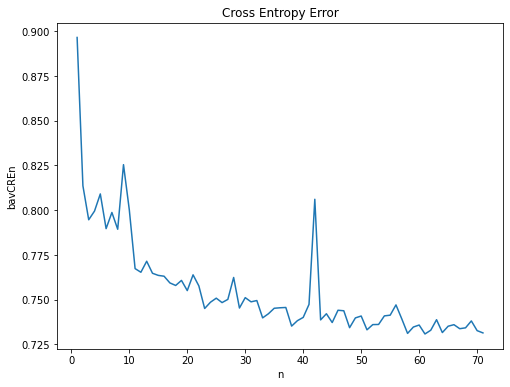

In [ ]:
plt.figure(figsize = (8,6)) 
plt.plot(np.arange(1,last_epoch+1,1),model_sum['val_loss']) 
plt.xlabel('n')
plt.ylabel('bavCREn')
plt.title('Cross Entropy Error')

Cross Entropy Loss compares how well the probability distribution output by the softmax function matches the true labels of the data. The error rate for the first 71 epochs are shown above. The function was able to end early from the iteration loop since the error values remained stationary for 10 epochs. Although we can see that the curve decreases with an increase in epochs, indicating a decrease in cross entropy loss, the cross entropy loss is still relatively high. Each "bump" in the plot relates to the batch size, and we can see that we have frequent amounts of "bumps."  

***plot || W(n+1)- W(n)|| / ||Wn||*** 

In [ ]:
from numpy import linalg as LA
def ratio(arr1,arr2):
    return(LA.norm(arr2-arr1)/LA.norm(arr1))
weight_ratio=[]
D=len(GradsReal_loss.weight[0])
epo_real=len(GradsReal_loss.weight) # the number of ran epoch
# it is <= epo because of interrupt learning
for i in range(epo_real-1):
    weight_ratio.append(ratio(GradsReal_loss.weight[i],GradsReal_loss.weight[i+1]))

Text(0.5, 1.0, '||W(n+1)- W(n)||/||Wn|| Plot')

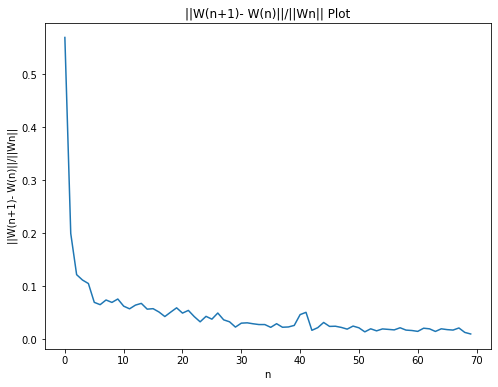

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(weight_ratio)
plt.xlabel('n')
plt.ylabel('||W(n+1)- W(n)||/||Wn||') 
plt.title('||W(n+1)- W(n)||/||Wn|| Plot')

W(n) is all of the weights and thresholds​ from epoch(n). This plot takes W(n) and subtracts them from all the weights and thresholds (​W(n+1))​) from epoch(n+1). It then calculates the norm, and divides that norm by the norm of (​W(n))​). This shows us the percent of change in the norms between epoch(n) and epoch(n+1). Initially, we see the percent of change is at around 60%. This means that there is a large change in weights and thresholds between epoch(1) and epoch(2). We see that the curve decreases quickly, indicating that there is not a substantial change in the weights between epochs as epoch size increases. This shows us that the MLP is learning the best weights to use initially and then slightly adjusting the weights as we increase epoch size.

***plot  ||Gn|| / d*** 

Text(0.5, 1.0, '||G(n)||/d Plot')

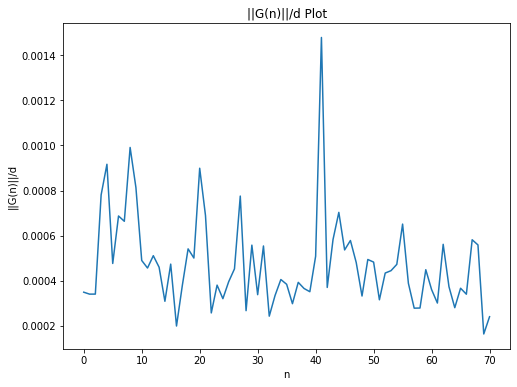

In [ ]:
layer1_dim=X_train.shape[0]
layerH_dim=best_h
layer2_dim=3

D = np.sqrt(layer1_dim*layerH_dim + layerH_dim + layerH_dim*layer2_dim + layer2_dim)

#check length of W
#print(len(GradsReal_loss.weight[0]))

plt.figure(figsize = (8,6))
plt.plot(GradsReal_loss.gradsNorm/D)
plt.xlabel('n') 
plt.ylabel('||G(n)||/d') 
plt.title('||G(n)||/d Plot')

The value of the gradient shows you the direction to a local minimum, but doesn't show how far it is. <br>
We see from the plot for the gradient norm that after each epoch the training results shows high error variation. However, we can see a decreasing trend during the procedure, and the oscillations seem to decrease. We could use a more efficient step selection in order to reduce this variation error, however, it could be extremely costly.

**Performance Analysis**

Text(0.5, 1.0, 'Performance on Training and Test Data Set: hl = 24')

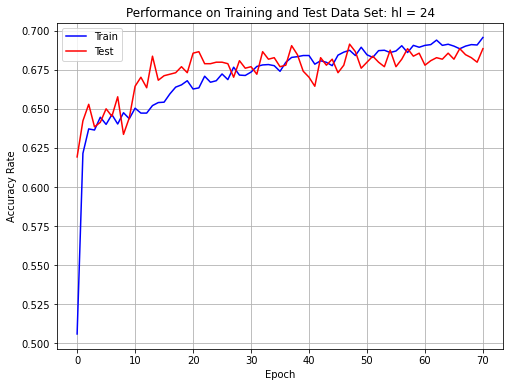

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(modelbest.history['accuracy'], color='blue', label='Train')
plt.plot(modelbest.history['val_accuracy'], color='red', label='Test')
plt.legend()
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Rate')
plt.title('Performance on Training and Test Data Set: hl = 24',fontsize=12)

As previously mentioned, the function stopped at 71 epochs.  We computed the training accuracy and test accuracy after the completion of each epoch. The resulting line plot of the training and test performance rates are shown in the plot above. The results indicate a low performance rate of approximately 70%. There seems to be a sign of overfitting since there is a gap between the test and training set. Since the initial model ran for 100 epochs and we set the model to have a patience of 10 epochs, epoch(71) is the ideal epoch size for the model.

In [ ]:
from tensorflow.keras.models import load_model

# Restore the best model and calculate confusion matrices.

model = load_model('BestModel.h5')
y_train_pred = model.predict(X_train.values)
y_test_pred = model.predict(X_test.values)

cm_train=tf.math.confusion_matrix(np.argmax(Y_train, axis=1), 
                               np.argmax(y_train_pred, axis=1),                  
                               num_classes=3).numpy()

cm_test=tf.math.confusion_matrix(np.argmax(Y_test, axis=1), 
                               np.argmax(y_test_pred, axis=1),
                               num_classes=3).numpy()
# Access gradients history by 'GradsReal_loss.grads' and 'GradsReal_loss.gradsNorm'.

***Train Set***

In [ ]:
cm_train

array([[1443,  147,  216],
       [ 173, 1068,   58],
       [ 520,  167,  364]], dtype=int32)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(np.around(cm,2))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.8  0.08 0.12]
 [0.13 0.82 0.04]
 [0.49 0.16 0.35]]


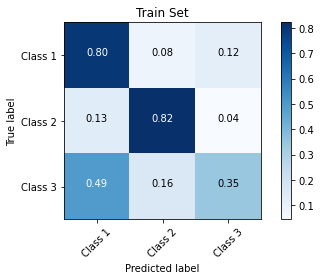

In [ ]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_train, classes=['Class 1','Class 2', 'Class 3'], normalize=True, 
                      title='Train Set')

In the training set, Class 1 was correctly classified 80% of the time, but was incorrectly classified as Class 2 8% and as Class 3 12%. Class 2 was correctly classified 82% of the time, but was incorrectly classified as Class 1 13% and as Class 3 4%. Class 3 had an extremely poor classification result; it was correctly classified 35% of the time and was mainly classified as Class 1 49% of the time. It was incorrectly classified as Class 2 16% of the time. When looking at the mean and standard deviation table of Class 1, Class 2, and Class 3 presented at the beginning, it's worth noting that the means and standard deviations of Class 1 and Class 3 are *extremely* similar, with Class 2 having more of a differentiation between values. This may be a possibilty as to why Class 3 is being classified as Class 1. Since Class 1 was predicted as Class 1 > Class 3 > Class 2, this may further show that the similarities betweeen the 2 classes may have had an effect on the classification.

***Test Set***

In [ ]:
cm_test

array([[366,  34,  52],
       [ 46, 269,  10],
       [146,  47,  70]], dtype=int32)

Normalized confusion matrix
[[0.81 0.08 0.12]
 [0.14 0.83 0.03]
 [0.56 0.18 0.27]]


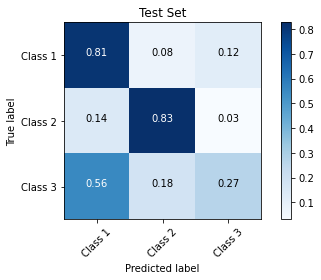

In [ ]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_test, classes=['Class 1','Class 2', 'Class 3'], normalize=True, 
                      title='Test Set')

In the test set, Class 1 was classified correctly 81% of the time, was classified as Class 2 8% of the time, and was classified as Class 3 12% of the time. Class 2 was correctly classified 83% of the time, incorrectly classified as Class 1 14% of the time, and incorrectly classified as Class 3 3%. Once again, Class 3 had the poorest results. It was correctly classified 27% of the time, classified as Class 1 56% of the time, and classified as Class 2 27% of the time. 

In [ ]:
# Overall Performance Rate of Training and Test Data Sets for Last Epoch and t heir Confidence Intervals
train_accuracy = model_sum['accuracy'][last_epoch-1]
CI_TRAIN = train_accuracy + np.array([-1,1])*norm.ppf(1.95/2)*np.sqrt(train_accuracy*(1-train_accuracy)/4156)
test_accuracy = model_sum['val_accuracy'][last_epoch-1]
CI_TEST = test_accuracy + np.array([-1,1])*norm.ppf(1.95/2)*np.sqrt(test_accuracy*(1-test_accuracy)/1040)
print('Training Accuracy:',100*train_accuracy.round(3)) 
print('Training 95% CI:', 100*CI_TRAIN.round(4)) 
print('Test Accuracy:',100*test_accuracy.round(3)) 
print('Test 95% CI:', 100*CI_TEST.round(4))

Training Accuracy: 69.6
Training 95% CI: [68.16 70.96]
Test Accuracy: 68.8
Test 95% CI: [66.03 71.66]


We have a training accuracy of 69.6% and a test accuracy of 68.8%. This is a low performance which may be due to the incorrect classification of Class 3. The confidence interval for the training accuracy and the test accuracy overlap, showing that there is no significant difference between the training and test set predictions. 

**Analysis of Hidden Layer**

In [ ]:
Houtput = pd.DataFrame(model.layers[0](X_train.values).numpy())
abs(Houtput).sum()[abs(Houtput).sum() == 0]



Series([], dtype: float32)

In [ ]:
 Houtput = model.layers[0](X_train.values).numpy() 
 Houtput.shape

(4156, 24)

In [ ]:
hl

24

In [ ]:
h_size = hl

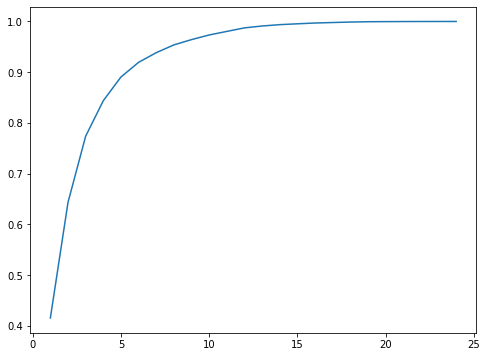

In [ ]:
plt.figure(figsize=(8,6))
pca = PCA().fit(Houtput) 
plt.plot(np.arange(1,h_size+1,1),np.cumsum(pca.explained_variance_ratio_))

In [ ]:
print(100*np.cumsum(pca.explained_variance_ratio_).round(4))

[ 41.52      64.32      77.37      84.37      89.04      91.939995
  93.84      95.380005  96.42      97.34      98.04      98.729996
  99.1       99.37      99.54      99.69      99.79      99.89
  99.95      99.97      99.98      99.99     100.       100.      ]


In [ ]:
# Average activities of neurons in hidden layer
label_train=np.argmax(Y_train, axis=1)

PROF0=np.mean(Houtput[label_train==0], axis=0)
#print(PROF0)

PROF1=np.mean(Houtput[label_train==1], axis=0)
#print(PROF1)

PROF2=np.mean(Houtput[label_train==2], axis=0)
#print(PROF2)

PROFj = pd.concat([df(PROF0),df(PROF1),df(PROF2)],axis=1) 
PROFj.columns = ['CL0','CL1','CL2']
print(PROFj.round(4))

       CL0     CL1     CL2
0   0.4678  0.1699  0.5880
1   0.0477  0.2266  0.0554
2   0.0451  0.3307  0.0597
3   0.4284  1.0893  0.4043
4   0.4408  0.2372  0.4465
5   0.1489  0.3923  0.1451
6   0.8013  0.4252  0.8237
7   0.4987  0.3215  0.5305
8   0.2701  0.2783  0.3026
9   0.2807  0.7019  0.3468
10  0.4931  0.5118  0.5515
11  0.0861  0.3148  0.1043
12  0.0695  0.0438  0.0609
13  0.3137  0.1453  0.3153
14  0.4293  0.4971  0.4532
15  0.2207  0.3007  0.2433
16  0.1700  1.0637  0.2555
17  0.1158  0.0282  0.1397
18  0.7198  0.2012  0.6494
19  0.4158  0.9657  0.5674
20  0.7662  0.3499  0.7430
21  0.1514  0.7451  0.2433
22  0.4842  0.5809  0.4942
23  0.0987  0.2083  0.1602


The profile of the 24 neurons. We want to focus on the neurons that have the greatest activity difference between classes in order to potentially remove the neurons that aren't as helpful in differentiating classes.

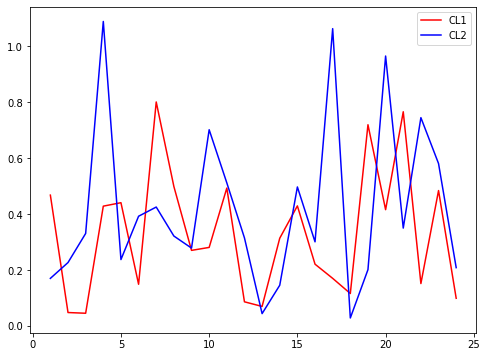

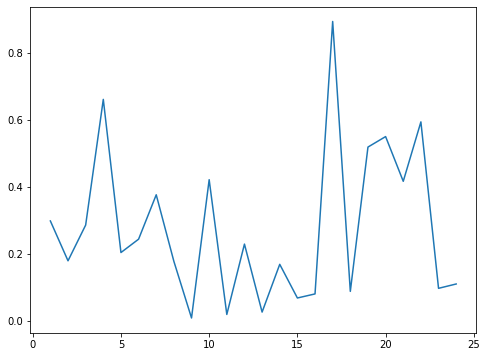

Best hidden neuron:
 [[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [10]
 [12]
 [14]
 [17]
 [19]
 [20]
 [21]
 [22]
 [24]]


In [ ]:
plt.figure(figsize=(8,6)) 
plt.plot(np.arange(1,h_size+1,1),PROF0,'red',label='CL1') 
plt.plot(np.arange(1,h_size+1,1),PROF1,'blue',label='CL2') 
plt.legend()
plt.show()
diff01 = np.abs(np.subtract(PROF0,PROF1)) 
plt.figure(figsize=(8,6)) 
plt.plot(np.arange(1,h_size+1,1),diff01)
plt.show()
print('Best hidden neuron:\n',np.argwhere(diff01>0.1)+1)

The hidden neurons that achieved the best differentiation between Class 1 and Class 2 were neurons [1,2,3,4,5,6,7,8,10,12,14,17,19,20,21,22,24]. 

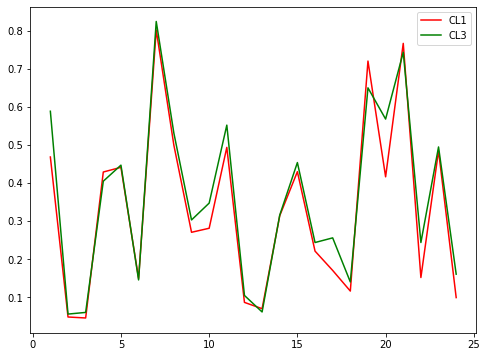

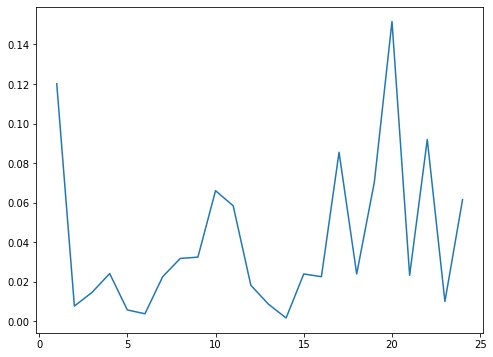

Best hidden neuron:
 [[ 1]
 [20]]


In [ ]:
plt.figure(figsize=(8,6)) 
plt.plot(np.arange(1,h_size+1,1),PROF0,'red',label='CL1') 
plt.plot(np.arange(1,h_size+1,1),PROF2,'green',label='CL3') 
plt.legend()
plt.show()
diff02 = np.abs(np.subtract(PROF0,PROF2)) 
plt.figure(figsize=(8,6)) 
plt.plot(np.arange(1,h_size+1,1),diff02)
plt.show()
print('Best hidden neuron:\n',np.argwhere(diff02>0.1)+1)

The hidden neurons that achieved the best differentiation between Class 1 and Class 3 were neurons [1,20].

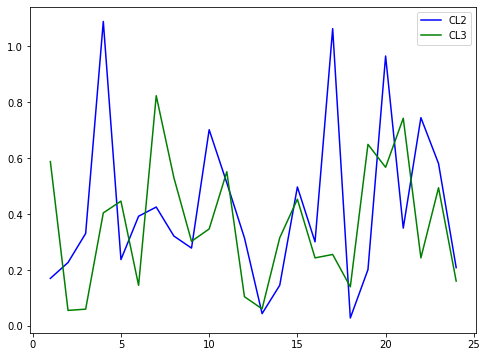

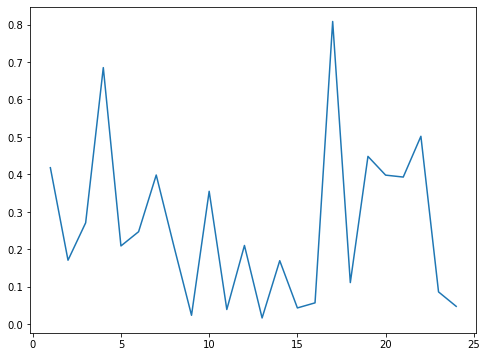

Best hidden neuron:
 [[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [10]
 [12]
 [14]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]]


In [ ]:
plt.figure(figsize=(8,6)) 
plt.plot(np.arange(1,h_size+1,1),PROF1,'blue',label='CL2') 
plt.plot(np.arange(1,h_size+1,1),PROF2,'green',label='CL3') 
plt.legend()
plt.show()
diff12 = np.abs(np.subtract(PROF1,PROF2)) 
plt.figure(figsize=(8,6)) 
plt.plot(np.arange(1,h_size+1,1),diff12)
plt.show()
print('Best hidden neuron:\n',np.argwhere(diff12>0.1)+1)

The hidden neurons that achieved the best differentiation between Class 2 and Class 3 were neurons [1,2,3,4,5,6,7,8,10,12,14,17,18,19,20,21,22].

The neurons most important to keep are the ones that are great at differentiating between classes. The neurons that differentiate between Class 1 and Class 2 are the same as those between Class 2 and Class 3, except for neurons 18 and 24. Only hidden neurons 1 and 20 were the best at differentiating between Class 1 and Class 3. This explains why there is such a poor correct classification of Class 3; only two neurons are good at differentiating between the two classes. Theses neuron may not have the largest weight compared to the other neurons, which would be one of the possible explanations as to why the classification of Class 3 was so poor. Neurons 9,11,13,15,16,and 23 were not considered good neurons at differentiating between classes. These neurons aren't as useful for our analysis. 